In [1]:
%load_ext sql
%sql mysql+pymysql://root@localhost/myemployees

'Connected: root@myemployees'

In [7]:
%sql CREATE TABLE if not exists t (\
    id INT PRIMARY KEY, \
    c VARCHAR(100)\
) Engine=InnoDB CHARSET=utf8;
%sql INSERT INTO t VALUES(1, '刘备');

 * mysql+pymysql://root@localhost/myemployees
0 rows affected.
 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (3719, "'utf8' is currently an alias for the character set UTF8MB3, but will be an alias for UTF8MB4 in a future release. Please consider using UTF8MB4 in order to be unambiguous.")
  result = self._query(query)
/Users/guwanhua/venv36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1050, "Table 't' already exists")
  result = self._query(query)


[]

# MVCC是什么

之前一直不理解MVCC是什么含义，什么叫多版本控制？mysql的版本是什么玩意？经常看到MVCC和事务隔离、MVCC和锁等相关术语，刚开始接触mysql的时候一头雾水。等博主理解了事务隔离级别和mysql锁相关的相关知识之后，再看MVCC的时候才有了一点体会。MVCC主要是为了事务隔离级别来服务的，能让一个事务在写记录的同时另一个事务去读记录，或者一个事务在读记录的时候另一个事务在写记录。换言之，可以使不同事务的读-写、写-读操作并发执行，从而提升系统性能。MVCC维护一个版本记录表，其中版本记录表维护其实也是依靠了锁来完成的。

## undo和redo

### undo 
undo log主要记录的是数据的逻辑变化，为了在发生错误时回滚之前的操作，需要将之前的操作都记录下来，然后在发生错误时才可以回滚。

undo是一种逻辑日志，有两个作用：
1. 用于事务的回滚
2. MVCC

### redo

redo(记录了事务的行为，可以很好的通过其对页进行"重做"操作.在一个事务中的每一次SQL操作之后都会写入一个redo log到buffer中，在最后COMMIT的时候，必须先将该事务的所有日志写入到redo log file进行持久化（这里的写入是顺序写的），待事务的COMMIT操作完成才算完成。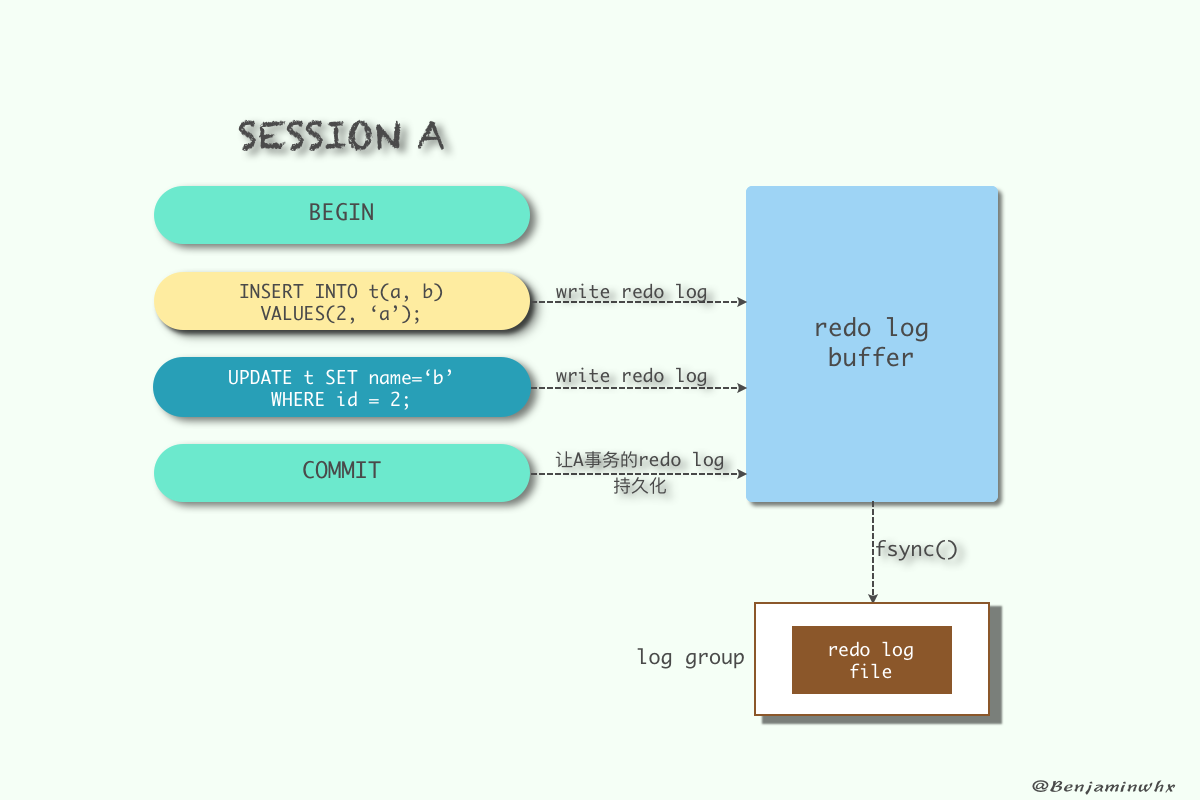

binlog为了解决Mysql主从备份而产生,redo log和bin log的数据一直性和完整性的保证. 但是redo和binlog两种日志记录写入磁盘的时间点不同，binlog只在事务提交完成后一次性写入，而redo log在上面也说了是在事务进行中不断被写入，这表现为日志并不是随事务提交的顺序进行写入的。

## 版本链
 
对于使用InnoDB存储引擎的表来说，它的聚簇索引记录中都包含两个必要的隐藏列：
1. trx_id：每次对某条聚簇索引记录进行改动时，都会把对应的事务id赋值给trx_id隐藏列。
2. roll_pointer：每次对某条聚簇索引记录进行改动时，都会把旧的版本写入到undo日志中，然后这个隐藏列就相当于一个指针，可以通过它来找到该记录修改前的信息。



In [8]:
%sql select * from t;

 * mysql+pymysql://root@localhost/myemployees
1 rows affected.


[(1, '刘备')]

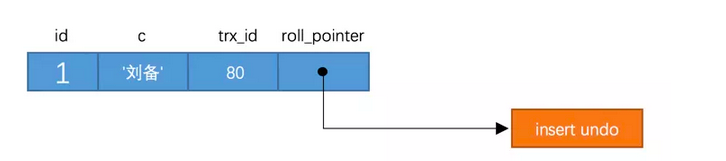

假设之后两个id分别为100、200的事务对这条记录进行UPDATE操作，操作流程如下：
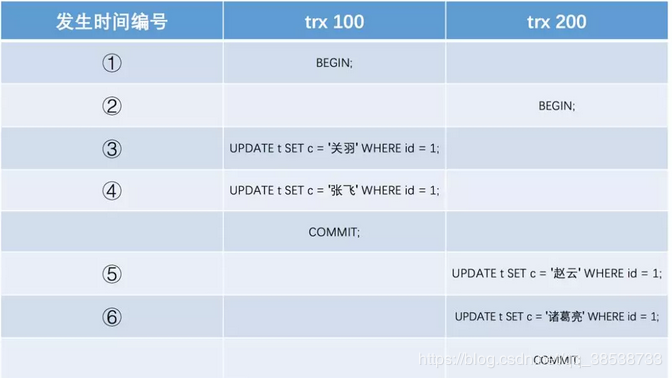
这里涉及了锁：第一个事务更新了某条记录后，就会给这条记录加锁，另一个事务再次更新时就需要等待第一个事务提交了，把锁释放之后才可以继续更新。

每次对记录进行改动(即使没有commit)，都会记录一条undo日志，每条undo日志也都有一个roll_pointer属性（INSERT操作对应的undo日志没有该属性，因为该记录并没有更早的版本），可以将这些undo日志都连起来，串成一个链表，所以现在的情况就像下图一样：
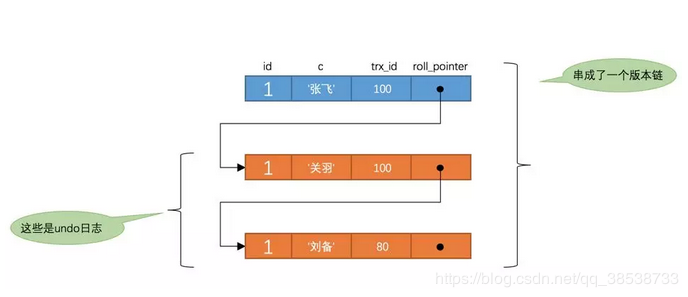
对该记录每次更新后，都会将旧值放到一条undo日志中，就算是该记录的一个旧版本，随着更新次数的增多，所有的版本都会被roll_pointer属性连接成一个链表，我们把这个链表称之为版本链，版本链的头节点就是当前记录最新的值。另外，每个版本中还包含生成该版本时对应的事务id.

我们发现，针对id=1这条记录，事务id是从80，到100，再到200，并不是交错地80，100，200，100，200，这是innodb的行锁保证的。

## ReadView

对于使用READ UNCOMMITTED隔离级别的事务来说，直接读取记录的最新版本就好了，对于使用SERIALIZABLE隔离级别的事务来说，使用加锁的方式来访问记录。对于使用READ COMMITTED和REPEATABLE READ隔离级别的事务来说，就需要用到我们上边所说的版本链了，核心问题就是：需要判断一下版本链中的哪个版本是当前事务可见的。所以设计InnoDB的大叔提出了一个ReadView的概念，这个ReadView中主要包含当前系统中还有哪些活跃的读写事务，把它们的事务id放到一个列表中，我们把这个列表命名为为m_ids。这样在访问某条记录时，只需要按照下边的步骤判断记录的某个版本是否可见. <font color="red">值得一提的是，这里的readview不是固定的，只有每次select的时候才会生成m_ids列表。</font>
1. 如果被访问版本的trx_id属性值小于m_ids列表中最小的事务id，表明生成该版本的事务在生成ReadView前已经提交，所以该版本可以被当前事务访问。
2. 如果被访问版本的trx_id属性值大于m_ids列表中最大的事务id，表明生成该版本的事务在生成ReadView后才生成，所以该版本不可以被当前事务访问。
3. 如果被访问版本的trx_id属性值在m_ids列表中最大的事务id和最小事务id之间，那就需要判断一下trx_id属性值是不是在m_ids列表中，如果在，说明创建ReadView时生成该版本的事务还是活跃的，该版本不可以被访问；如果不在，说明创建ReadView时生成该版本的事务已经被提交，该版本可以被访问。


如果某个版本的数据对当前事务不可见的话，那就顺着版本链找到下一个版本的数据，继续按照上边的步骤判断可见性，依此类推，直到版本链中的最后一个版本，如果最后一个版本也不可见的话，那么就意味着该条记录对该事务不可见，查询结果就不包含该记录。

<font color="red">在MySQL中，READ COMMITTED和REPEATABLE READ隔离级别的的一个非常大的区别就是它们生成ReadView的时机不同</font>

### READ COMMITTED --- 每次读取数据前都生成一个ReadView

比方说现在系统里有两个id分别为100、200的事务在执行：
```
# Transaction 100
BEGIN;
 
UPDATE t SET c = '关羽' WHERE id = 1;
 
UPDATE t SET c = '张飞' WHERE id = 1;
```

```
# Transaction 200
BEGIN;
 
# 更新了一些别的表的记录
...
```
注意：事务执行过程中，只有在第一次真正修改记录时（比如使用INSERT、DELETE、UPDATE语句），才会被分配一个单独的事务id，这个事务id是递增的。

此刻，表t中id为1的记录得到的版本链表如下所示：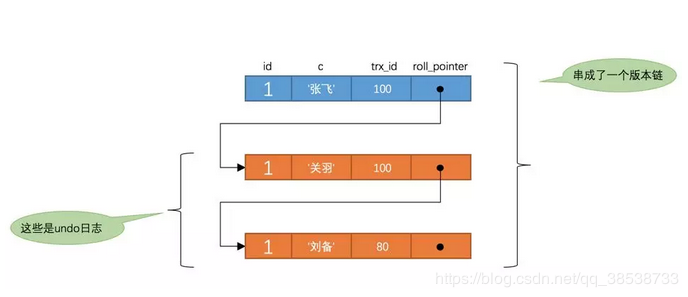

假设现在有一个使用READ COMMITTED隔离级别的事务开始执行：
```

# 使用READ COMMITTED隔离级别的事务
BEGIN;
 
# SELECT1：Transaction 100、200未提交
SELECT * FROM t WHERE id = 1; # 得到的列c的值为'刘备'
```

这个SELECT1的执行过程如下:
1. 在执行SELECT语句时会先生成一个ReadView，ReadView的m_ids列表的内容就是[100, 200]。
2. 然后从版本链中挑选可见的记录，从图中可以看出，最新版本的列c的内容是'张飞'，该版本的trx_id值为100，在m_ids列表内，所以不符合可见性要求，根据roll_pointer跳到下一个版本。
3. 下一个版本的列c的内容是'关羽'，该版本的trx_id值也为100，也在m_ids列表内，所以也不符合要求，继续跳到下一个版本。
4. 下一个版本的列c的内容是'刘备'，该版本的trx_id值为80，小于m_ids列表中最小的事务id100，所以这个版本是符合要求的，最后返回给用户的版本就是这条列c为'刘备'的记录

之后，我们把事务id为100的事务提交一下，就像这样：
```
# Transaction 100
BEGIN;
 
UPDATE t SET c = '关羽' WHERE id = 1; 
UPDATE t SET c = '张飞' WHERE id = 1;
 
COMMIT;
```
然后再到事务id为200的事务中更新一下表t中id为1的记录：
```
# Transaction 200
BEGIN;
 
# 更新了一些别的表的记录
...
 
UPDATE t SET c = '赵云' WHERE id = 1;
UPDATE t SET c = '诸葛亮' WHERE id = 1;
```
此刻，表t中id为1的记录的版本链就长这样：

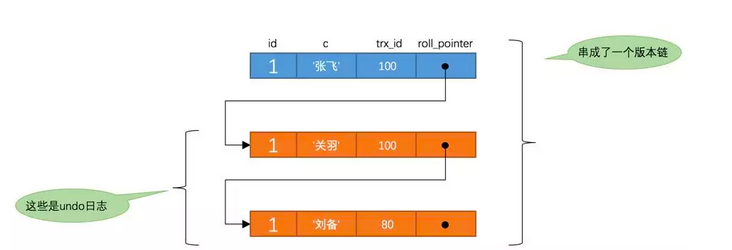

然后再到刚才使用READ COMMITTED隔离级别的事务中继续查找这个id为1的记录，如下：
```
# 使用READ COMMITTED隔离级别的事务
BEGIN;
 
# SELECT1：Transaction 100、200均未提交
SELECT * FROM t WHERE id = 1; # 得到的列c的值为'刘备'
 
# SELECT2：Transaction 100提交，Transaction 200未提交
SELECT * FROM t WHERE id = 1; # 得到的列c的值为'张飞'
```
这个SELECT2的执行过程如下：
1. 在执行SELECT语句时会先生成一个ReadView，ReadView的m_ids列表的内容就是[200]（事务id为100的那个事务已经提交了，所以生成快照时就没有它了）。
2. 然后从版本链中挑选可见的记录，从图中可以看出，最新版本的列c的内容是'诸葛亮'，该版本的trx_id值为200，在m_ids列表内，所以不符合可见性要求，根据roll_pointer跳到下一个版本。
3. 下一个版本的列c的内容是'赵云'，该版本的trx_id值为200，也在m_ids列表内，所以也不符合要求，继续跳到下一个版本。
4. 下一个版本的列c的内容是'张飞'，该版本的trx_id值为100，比m_ids列表中最小的事务id200还要小，所以这个版本是符合要求的，最后返回给用户的版本就是这条列c为'张飞'的记录。
 
以此类推，如果之后事务id为200的记录也提交了，再此在使用READ COMMITTED隔离级别的事务中查询表t中id值为1的记录时，得到的结果就是'诸葛亮'了，具体流程我们就不分析了。总结一下就是：使用READ COMMITTED隔离级别的事务在每次查询开始时都会生成一个独立的ReadView。

### REPEATABLE READ ---在第一次读取数据时生成一个ReadView

对于使用REPEATABLE READ隔离级别的事务来说，只会在第一次执行查询语句时生成一个ReadView，之后的查询就不会重复生成了。
比方说现在系统里有两个id分别为100、200的事务在执行：
```
# Transaction 100
BEGIN;
 
UPDATE t SET c = '关羽' WHERE id = 1;
 
UPDATE t SET c = '张飞' WHERE id = 1;
```

```
# Transaction 200
BEGIN;
 
# 更新了一些别的表的记录
...
```

此刻，表t中id为1的记录得到的版本链表如下所示：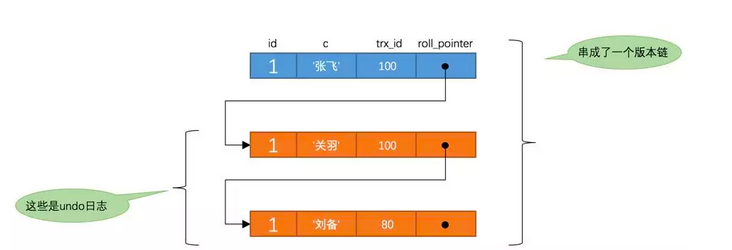

假设现在有一个使用REPEATABLE READ隔离级别的事务开始执行：
```
# 使用REPEATABLE READ隔离级别的事务
BEGIN;
 
# SELECT1：Transaction 100、200未提交
SELECT * FROM t WHERE id = 1; # 得到的列c的值为'刘备'
```

这个SELECT1的执行过程如下：
1. 在执行SELECT语句时会先生成一个ReadView，ReadView的m_ids列表的内容就是[100, 200]。
2. 然后从版本链中挑选可见的记录，从图中可以看出，最新版本的列c的内容是'张飞'，该版本的trx_id值为100，在m_ids列表内，所以不符合可见性要求，根据roll_pointer跳到下一个版本。
3. 下一个版本的列c的内容是'关羽'，该版本的trx_id值也为100，也在m_ids列表内，所以也不符合要求，继续跳到下一个版本。
4. 下一个版本的列c的内容是'刘备'，该版本的trx_id值为80，小于m_ids列表中最小的事务id100，所以这个版本是符合要求的，最后返回给用户的版本就是这条列c为'刘备'的记录。
 
之后，我们把事务id为100的事务提交一下，就像这样：

```
# Transaction 100
BEGIN; 
UPDATE t SET c = '关羽' WHERE id = 1; 
UPDATE t SET c = '张飞' WHERE id = 1; 
COMMIT;
```

然后再到事务id为200的事务中更新一下表t中id为1的记录：
```
# Transaction 200
BEGIN;
 
# 更新了一些别的表的记录
...
 
UPDATE t SET c = '赵云' WHERE id = 1; 
UPDATE t SET c = '诸葛亮' WHERE id = 1;
```

此刻，表t中id为1的记录的版本链就长这样：


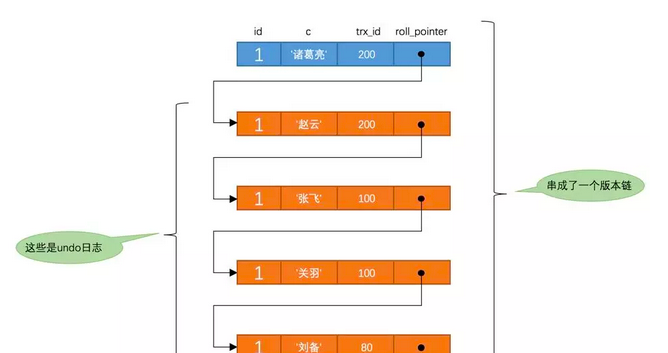

然后再到刚才使用REPEATABLE READ隔离级别的事务中继续查找这个id为1的记录，如下：

```
# 使用REPEATABLE READ隔离级别的事务
BEGIN;
 
# SELECT1：Transaction 100、200均未提交
SELECT * FROM t WHERE id = 1; # 得到的列c的值为'刘备'
 
# SELECT2：Transaction 100提交，Transaction 200未提交
SELECT * FROM t WHERE id = 1; # 得到的列c的值仍为'刘备'
```

这个SELECT2的执行过程如下：
1. 因为之前已经生成过ReadView了，所以此时直接复用之前的ReadView，之前的ReadView中的m_ids列表就是[100, 200]。
2. 然后从版本链中挑选可见的记录，从图中可以看出，最新版本的列c的内容是'诸葛亮'，该版本的trx_id值为200，在m_ids列表内，所以不符合可见性要求，根据roll_pointer跳到下一个版本。
3. 下一个版本的列c的内容是'赵云'，该版本的trx_id值为200，也在m_ids列表内，所以也不符合要求，继续跳到下一个版本。
4. 下一个版本的列c的内容是'张飞'，该版本的trx_id值为100，而m_ids列表中是包含值为100的事务id的，所以该版本也不符合要求，同理下一个列c的内容是'关羽'的版本也不符合要求。继续跳到下一个版本。
5. 下一个版本的列c的内容是'刘备'，该版本的trx_id值为80，80小于m_ids列表中最小的事务id100，所以这个版本是符合要求的，最后返回给用户的版本就是这条列c为'刘备'的记录。
 
也就是说两次SELECT查询得到的结果是重复的，记录的列c值都是'刘备'，这就是可重复读的含义。如果我们之后再把事务id为200的记录提交了，之后再到刚才使用REPEATABLE READ隔离级别的事务中继续查找这个id为1的记录，得到的结果还是'刘备'

**所谓的MVCC（Multi-Version Concurrency Control ，多版本并发控制）指的就是在使用READ COMMITTD、REPEATABLE READ这两种隔离级别的事务在执行普通的SEELCT操作时访问记录的版本链的过程，这样子可以使不同事务的读-写、写-读操作并发执行，从而提升系统性能。READ COMMITTD、REPEATABLE READ这两个隔离级别的一个很大不同就是生成ReadView的时机不同，READ COMMITTD在每一次进行普通SELECT操作前都会生成一个ReadView，而REPEATABLE READ只在第一次进行普通SELECT操作前生成一个ReadView，之后的查询操作都重复这个ReadView就好了。！**